# Meta-analysis of LCIA methods

This notebook assumes you have completed the `Getting started with Brighway2` notebook.

This notebook shows the real power of Brightway2, and in particular the ability to script and analyze many LCA calculations.

At the end of this notebook, you should:

* Be able to make many LCA calculations
* Use `multiprocessing` to utilize the full power of your computer
* Store calculations results in `numpy` arrays, for analysis and interpretation
* Use matplotlib to display results graphically

If you finish the notebook, you get another kitten!

You should **download this notebook** and run it cell by cell - don't just read it on the web!

# Starting at the beginning

Import brightway2.

In [1]:
from brightway2 import *

## Copy our work from introductory notebook

And change to our new project.

In [2]:
if "BW2 introduction" not in projects:
        raise ValueError("Must have run introductory notebook already!")
        
if "Meta-analysis" not in projects:
    projects.set_current("BW2 introduction")
    projects.copy_project("Meta-analysis")
else:
    projects.set_current("Meta-analysis")

assert 'forwast' in databases, "Something went wrong - please run the introductory notebook again"

In [3]:
print("There are {} activities in our database".format(len(Database('forwast'))))

There are 277 activities in our database


Let's start by picking some LCIA methods to analyze - we don't want to use all the available ones, as many are specific to just a few biosphere flows, and it wouldn't make sense to compare these methods to other methods.

In [4]:
CANDIDATES = [
 ('CML 2001', 'acidification potential', 'average European'),
 ('CML 2001', 'climate change', 'GWP 100a'),
 ('CML 2001', 'eutrophication potential', 'average European'),
 ('CML 2001', 'freshwater aquatic ecotoxicity', 'FAETP 100a'),
 ('CML 2001', 'human toxicity', 'HTP 100a'),
 ('CML 2001', 'land use', 'competition'),
 ('CML 2001', 'marine aquatic ecotoxicity', 'MAETP infinite'),
 ('CML 2001', 'resources', 'depletion of abiotic resources'),
 ('CML 2001', 'stratospheric ozone depletion', 'ODP 25a'),
 ('EDIP2003', 'ecotoxicity', 'in sewage treatment plants'),
 ('EDIP2003', 'eutrophication', 'terrestrial eutrophication'),
 ('EDIP2003', 'renewable resources', 'wood'),
 ('EDIP2003', 'stratospheric ozone depletion', 'ODP total'),
 ('EPS 2000', 'total', 'abiotic stock resources'),
 ('EPS 2000', 'total', 'emissions into soil'),
 ('EPS 2000', 'total', 'emissions into water'),
 ('EPS 2000', 'total', 'land occupation'),
 ('IMPACT 2002+ (Endpoint)', 'ecosystem quality', 'land occupation'),
 ('IMPACT 2002+ (Endpoint)', 'human health', 'ozone layer depletion'),
 ('IMPACT 2002+ (Endpoint)', 'resources', 'mineral extraction'),
 ('IMPACT 2002+ (Endpoint)', 'resources', 'non-renewable energy'),
 ('IMPACT 2002+ (Midpoint)', 'ecosystem quality', 'aquatic acidification'),
 ('IPCC 2001', 'climate change', 'GWP 100a'),
 ('ReCiPe Endpoint (H,A)',
  'ecosystem quality',
  'agricultural land occupation'),
 ('ReCiPe Endpoint (H,A)',
  'ecosystem quality',
  'freshwater eutrophication'),
 ('ReCiPe Endpoint (H,A)',
  'ecosystem quality',
  'natural land transformation'),
 ('ReCiPe Endpoint (H,A)',
  'ecosystem quality',
  'terrestrial acidification'),
 ('ReCiPe Endpoint (H,A)', 'ecosystem quality', 'urban land occupation'),
 ('ReCiPe Endpoint (H,A)', 'human health', 'particulate matter formation'),
 ('ReCiPe Endpoint (H,A)', 'resources', 'fossil depletion'),
 ('TRACI', 'environmental impact', 'acidification'),
 ('TRACI', 'environmental impact', 'eutrophication'),
 ('TRACI', 'environmental impact', 'global warming'),
 ('TRACI', 'environmental impact', 'ozone depletion'),
 ('TRACI', 'human health', 'respiratory effects, average'),
 ('eco-indicator 99, (H,A)',
  'ecosystem quality',
  'acidification & eutrophication'),
 ('eco-indicator 99, (H,A)', 'ecosystem quality', 'ecotoxicity'),
 ('eco-indicator 99, (H,A)', 'ecosystem quality', 'land occupation'),
 ('eco-indicator 99, (H,A)', 'human health', 'carcinogenics'),
 ('eco-indicator 99, (H,A)', 'human health', 'climate change'),
 ('eco-indicator 99, (H,A)', 'human health', 'ozone layer depletion'),
 ('eco-indicator 99, (H,A)', 'resources', 'fossil fuels'),
 ('eco-indicator 99, (H,A)', 'resources', 'mineral extraction'),
 ('ecological footprint', 'total', 'CO2'),
 ('ecological footprint', 'total', 'land occupation'),
 ('ecological footprint', 'total', 'nuclear'),
 ('ecological scarcity 2006', 'total', 'deposited waste'),
 ('ecological scarcity 2006', 'total', 'emission into groundwater'),
 ('ecological scarcity 2006', 'total', 'energy resources'),
 ('ecological scarcity 2006', 'total', 'natural resources'),
 ('ecosystem damage potential', 'total', 'linear, land occupation'),
 ('ecosystem damage potential', 'total', 'linear, land transformation'),
]
print("There are {} methods to test".format(len(CANDIDATES)))

There are 52 methods to test


We will now compute an LCA score for each process in the `FORWAST` database, for each of these 52 methods. To do this, we use the [multiprocessing](https://docs.python.org/3.5/library/multiprocessing.html) library to dispatch jobs to each available CPU core on our machine. We will store our results in an [numpy](http://www.numpy.org/) array.

In [5]:
import multiprocessing
import numpy as np

First, we create a function that will calculate the LCA score for one method and a list of activities. To do this, we use the ability of the `LCA` class to factorize the technosphere matrix into two triangular matrices (this is what `lca.decompose_technosphere()` does), which will make the actual LCI calculations *very* fast, on the order of 100 per second.

There are one potentially tricky thing we need to be aware of. We use the convenience method `redo_lcia`. This will change the LCA demand vector, but will cause an error if the new demanded activity is not in the foreground and background databases that form the technosphere matrix. This is the whole point of `redo_lci` and `redo_lcia` - if the technosphere doesn't change, then we can make calculations faster. If it does change, then we might as well create a whole new `LCA` object. Because we are drawing our list of activities from the same database, this is no problem, but it could be if we were to sample from different databases.

In [6]:
def many_activities_one_method(activities, method):
    """
    Calculate LCA scores for many activities and one method. 
    
    Returns a 1-dimensional numpy array of scores in the same order as `activities`.
    
    Note that this assumes that all activities link to the same background databases, 
    i.e. the technosphere matrix doesn't change from one activity to the next.
    """
    output = np.zeros((len(activities),))        # LCA scores will be put here
    lca = LCA({activities[0]: 1}, method=method) # LCA object which will do all calculating
    lca.lci()                                    # Calculate inventory once to load all database data
    lca.decompose_technosphere()                 # Keep the LU factorized matrices for faster calculations
    lca.lcia()                                   # Load method data
    for index, activity_name in enumerate(activities):
        lca.redo_lcia({activity_name: 1})        # It is almost too easy...
        output[index] = lca.score
    return (method, output)

Now we define the function that will dispatch the activities and methods using a `multiprocessing` pool. This isn't particularly difficult - just get sorted lists of the inputs, and use `apply_async` (there are also other possibilities, see the [multiprocessing](https://docs.python.org/3.5/library/multiprocessing.html) documentation, or search for tutorials on the web.

In [7]:
def get_lots_of_lca_scores():
    """Compute LCA scores for all activities and all LCIA methods."""
    db_data = Database("forwast").load()
    activities = sorted(db_data.keys())             # Sort to make sure order is always the same
    candidates = sorted(CANDIDATES)                 # Sort to make sure order is always the same
    num_methods, num_processes = len(candidates), len(activities)

    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
    jobs = [pool.apply_async(
        many_activities_one_method,                 # Function
        (activities, method)                        # Inputs (activities are always the same, but method changes in the "for" loop)
    ) for method in candidates]
    pool.close()
    pool.join()                                     # Blocks doing anything more until calculation is finished
    results = dict([job.get() for job in jobs])

    output = np.zeros((num_processes, num_methods)) # Create array to store calculated results
    for index, method in enumerate(candidates):
        output[:, index] = results[method]          # Fill in a column of the results array
    return output, candidates, activities

Now, we are ready to do the actual calculation. Let's time it to see how long it takes us to make more than 50.000 LCA calculations...

In [8]:
from time import time

start = time()
lca_scores, methods, activities = get_lots_of_lca_scores()
print(time() - start)

5.817174911499023


More than 8.000 LCA calculations per second. Now we interpret these scores. Because they can be so different from method to method, if would be nice to normalize them. But first, let's do some basic sanity checks on the results:

In [9]:
print("Array shape:", lca_scores.shape)
print("Number of activities:", len(activities))
print("Average:", np.average(lca_scores))
print("Median (of absolute value):", np.median(np.abs(lca_scores)))
print("Min, Max:", np.min(lca_scores), np.max(lca_scores))
print("Fraction of all scores with score of zero:", (lca_scores == 0).sum() / float(lca_scores.shape[0] * lca_scores.shape[1]))
print("Methods where all scores are zero:", (lca_scores.sum(axis=0) == 0).sum())
print("Activities where all scores are zero:", (lca_scores.sum(axis=1) == 0).sum())
np.histogram(lca_scores)

Array shape: (277, 52)
Number of activities: 277
Average: 30560247080.1
Median (of absolute value): 0.0
Min, Max: -262.211210418 3.76229001741e+14
Fraction of all scores with score of zero: 0.538461538462
Methods where all scores are zero: 28
Activities where all scores are zero: 0


(array([14403,     0,     0,     0,     0,     0,     0,     0,     0,     1]),
 array([ -2.62211210e+02,   3.76229002e+13,   7.52458003e+13,
          1.12868701e+14,   1.50491601e+14,   1.88114501e+14,
          2.25737401e+14,   2.63360301e+14,   3.00983201e+14,
          3.38606102e+14,   3.76229002e+14]))

Now we need to figure out how to compare these scores. We have no information on the distribution of scores for each method, and no reason to think that they are e.g. normally distributed, so most of our paramteric statistics won't work. Instead, we can compute a [rank order correlation](http://en.wikipedia.org/wiki/Spearman's_rank_correlation_coefficient) coefficient, but using [Kendall's τ](http://en.wikipedia.org/wiki/Kendall_tau_rank_correlation_coefficient) instead of Spearman's ROCC, as in my experience it is a better discriminator.

In [10]:
from scipy import stats

def create_correlation_matrix(scores_array):
    num_methods = scores_array.shape[1]
    correlations = np.zeros((num_methods, num_methods))

    for row in range(num_methods):
        for col in range(num_methods):
            if col <= row:
                continue                               # Only need to compute correlation once
            dataset_1 = scores_array[:, row]
            dataset_2 = scores_array[:, col]
            mask = (dataset_1 != 0) * (dataset_2 != 0) # Ignore activities that have zero score
            corr = stats.kendalltau( # Get tau value, drop p-statistic
                dataset_1[mask], 
                dataset_2[mask]
            )[0]
            if np.isnan(corr):
                correlations[row, col] = 0
            else:
                correlations[row, col] = corr

    # Drop rows of zeros
    mask = correlations.sum(axis=0) != 0
    correlations = correlations[:, mask]

    # Drop columns of zeros
    mask = correlations.sum(axis=1) != 0
    correlations = correlations[mask, :]

    # correlations = correlations + correlations.T       # Make sorting easier by adding filling in lower left triangle
    return correlations

In [11]:
correlation_matrix = create_correlation_matrix(lca_scores)

Let's visualize this matrix.

By the way, I strongly recommend investigating the [seaborn](http://stanford.edu/~mwaskom/software/seaborn/index.html) graphing library for this kind of analysis. In this workbook, we use matplotlib, to avoid having to install more dependencies.

In [12]:
%matplotlib inline

We use the [cubehelix](http://www.ifweassume.com/2013/05/cubehelix-or-how-i-learned-to-love.html) colormap, which you should know about :)

(0.0, 22.0, 0.0, 22.0)

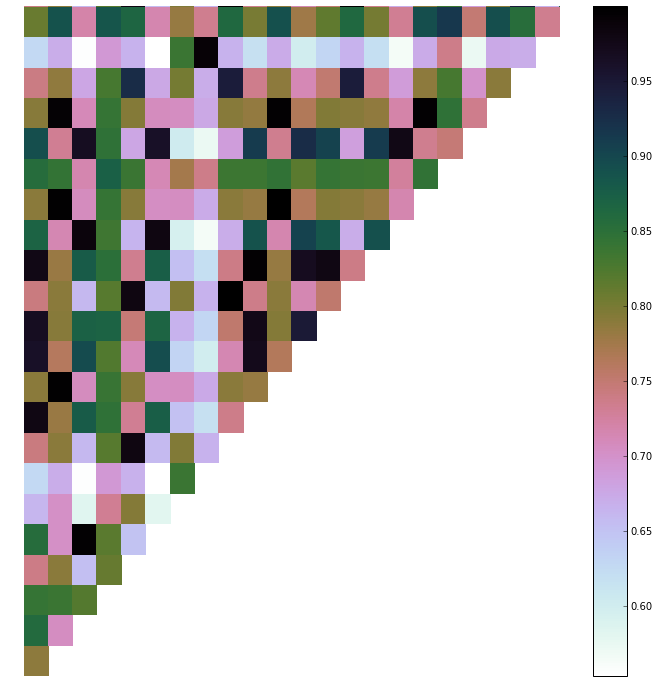

In [13]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(12, 12)

masked_correlation = np.ma.array(correlation_matrix, mask=correlation_matrix == 0).T
plt.pcolor(masked_correlation, cmap=plt.cm.cubehelix_r)
plt.colorbar()
plt.ylim(None, correlation_matrix.shape[1] - 1)
plt.xlim(None, correlation_matrix.shape[0] - 1)
plt.axis('off')

This is quite interesting. The first thing that jumps out at me is how strongly some methods are correlated. Of course, there will be many strong correlation, as many methods use the same factors for e.g. global warming, or the same model or assumption for e.g. ecotoxicity.

Let's find the two methods with the lowest negative correlation, and graph their actual values compared with their ranks:

In [14]:
print("Minimum correlation:", correlation_matrix.min())
# Get array indices
indices_min_correlation = np.unravel_index(np.argmin(correlation_matrix), correlation_matrix.shape)

Minimum correlation: 0.0


In [15]:
xs = lca_scores[:, indices_min_correlation[0]]
ys = lca_scores[:, indices_min_correlation[1]]
mask = (xs != 0) * (ys != 0)
print("Taking {} activities scores from {} possible".format(mask.sum(), xs.shape[0]))

Taking 277 activities scores from 277 possible


Lots of graphing code to make something decent - there is lots of discussion of matplotlib and its many, many functions all over the web.

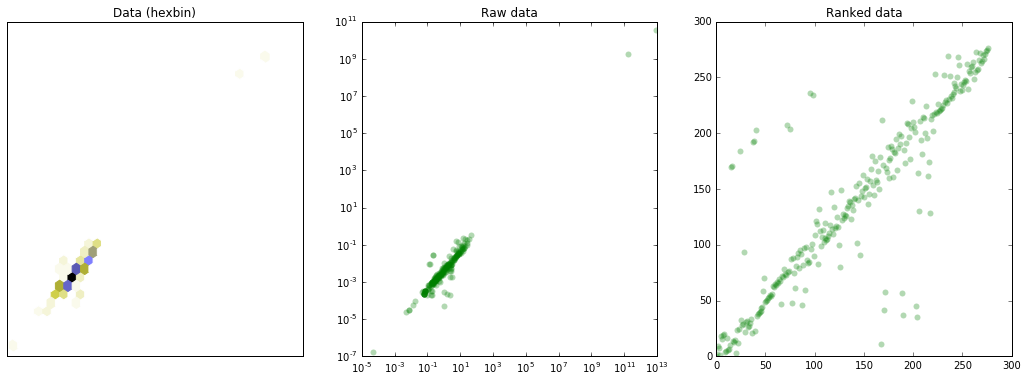

In [16]:
fig = plt.gcf()
fig.set_size_inches(18, 6)

ax = plt.subplot(131)
ax.hexbin(np.log(xs[mask]), np.log(ys[mask]), cmap=plt.cm.gist_stern_r, gridsize=30)
ax.set_xticks([])
ax.set_yticks([])
# TODO: Colorbar?
x_low, x_high = ax.get_xlim()
ax.set_xlim(x_low * 1.1, x_high * 1.2)
y_low, y_high = ax.get_ylim()
ax.set_ylim(y_low * 1.1, y_high * 1.2)
ax.set_title("Data (hexbin)")

ax = plt.subplot(132)
ax.loglog(
    xs[mask], 
    ys[mask], 
    marker=".",
    linestyle="None",
    alpha=0.3,
    markersize=12,
    mfc="g",
    mec="None"
)
ax.set_title("Raw data")

ax = plt.subplot(133)
ax.plot(
    np.argsort(np.argsort(xs[mask])),  # Ranks instead of data values
    np.argsort(np.argsort(ys[mask])),  # Ranks instead of data values 
    marker=".",
    linestyle="None",
    alpha=0.3,
    markersize=12,
    mfc="g",
    mec="None"
)
ax.set_title("Ranked data")